In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random as rnd

import warnings
#filter SettingWithCopyWarning
warnings.filterwarnings("ignore")

In [5]:
deseq_lrt = pd.read_csv("/home/carlos/Desktop/manuscripts/notebooks/RNA/all_deseq_lrt.tsv", sep="\t", )
deseq_lrt_names = list(deseq_lrt['external_gene_name'].unique())
#time_comp = "t0-t60"
time_comp = "t0-t12"

degs = pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/RNA/{time_comp}.degs.tsv", sep="\t", )

In [18]:
def prep_data(data, topN=10, use_stat="median", filter_count=10, deseq_lrt=None, return_additional: list =None, how="inner", filter_cont=True):

    ts_names = deseq_lrt["external_gene_name"].unique() if deseq_lrt is not None else None
    
    data["pValueLog"] = data["pValueLog"].astype(float)
    data["pValue"] = data.apply(lambda row: 10**(-row["pValueLog"]), axis=1)
    data = data.loc[data["pValue"] <= 0.05]

    

    counts = data.groupby('collection').count()
    data['count'] = data.apply(lambda row: counts.loc[row['collection']]['userSet'], axis=1)

    means = data.groupby('collection')[f"pValueLog"].mean()
    data['mean'] = data.apply(lambda row: means.loc[row['collection']], axis=1)

    maxs = data.groupby('collection')[f"pValueLog"].max()
    data['max'] = data.apply(lambda row: maxs.loc[row['collection']], axis=1)

    median = data.groupby('collection')[f"pValueLog"].median()
    data['median'] = data.apply(lambda row: median.loc[row['collection']], axis=1)

    mins = data.groupby('collection')[f"pValueLog"].min()
    data['min'] = data.apply(lambda row: mins.loc[row['collection']], axis=1)
    
    data = data.loc[data['count'] >= filter_count]
    data = data.sort_values(by=[use_stat], ascending=False)
    data.reset_index(inplace=True, drop=True)

    # Unique collection names and their ranks such as "1. JUND" "2. CTCF" "3. ...
    ranked_dict = {
        name: f"{i+1}. {name}" for i, name in enumerate(data['collection'].unique())
    }

    data['ranked_collection'] = data['collection'].apply(lambda x: ranked_dict[x])

    if return_additional is not None:
        additions_dfs = []
        for additional_tf in return_additional:
            addition_df = data.loc[data['collection'] == additional_tf]
            additions_dfs.append(addition_df)

    if deseq_lrt is not None and how == "inner" and filter_cont is True:
        data = data.loc[data['collection'].isin(ts_names)]
    elif deseq_lrt is not None and how == "outer" and filter_cont is True:
        data = data.loc[~data['collection'].isin(ts_names)]
    
    
    data = data.loc[data['collection'].isin(data['collection'].unique()[:topN])]

    if filter_cont is False:
        return data.reset_index(inplace=False, drop=True)

    data['dotColor'] = pd.Categorical(
        data['cellType'].apply(lambda x: "hela" if "HELA" in str(x).upper() else "non-hela"),
    )

    data_r = data.copy()    
    if return_additional is not None:
        for additional_tf_name, additional_tf_df in zip(return_additional, additions_dfs):
            if additional_tf_name in data_r['collection'].unique():
                continue
            else:
                data_r = pd.concat([data_r, additional_tf_df], axis=0)
        if deseq_lrt is not None:
            data_r['ts_padj'] = 1
            # for each gene name that is both in data.collecttion and deseq_lrt.external_gene_name, add its padj from deseqlrt to data
            for gene_name in data_r.collection.unique():
                if gene_name in ts_names:
                    ts_padj = deseq_lrt.loc[deseq_lrt['external_gene_name'] == gene_name, 'padj'].iloc[0]
                    data_r.loc[data_r['collection'] == gene_name, 'ts_padj'] = ts_padj
            data_r['log_ts_padj'] = data_r.apply(lambda row: -np.log10(row['ts_padj']), axis=1)
            return data_r.reset_index(inplace=False, drop=True)
    
    else:
        data_r['ts_padj'] = 1
            # for each gene name that is both in data.collecttion and deseq_lrt.external_gene_name, add its padj from deseqlrt to data
        for gene_name in data_r.collection.unique():
            if gene_name in ts_names:
                ts_padj = deseq_lrt.loc[deseq_lrt['external_gene_name'] == gene_name, 'padj'].iloc[0]
                data_r.loc[data_r['collection'] == gene_name, 'ts_padj'] = ts_padj
        data_r['log_ts_padj'] = data_r.apply(lambda row: -np.log10(row['ts_padj']), axis=1)
        return data_r.reset_index(inplace=False, drop=True)

## gnn res

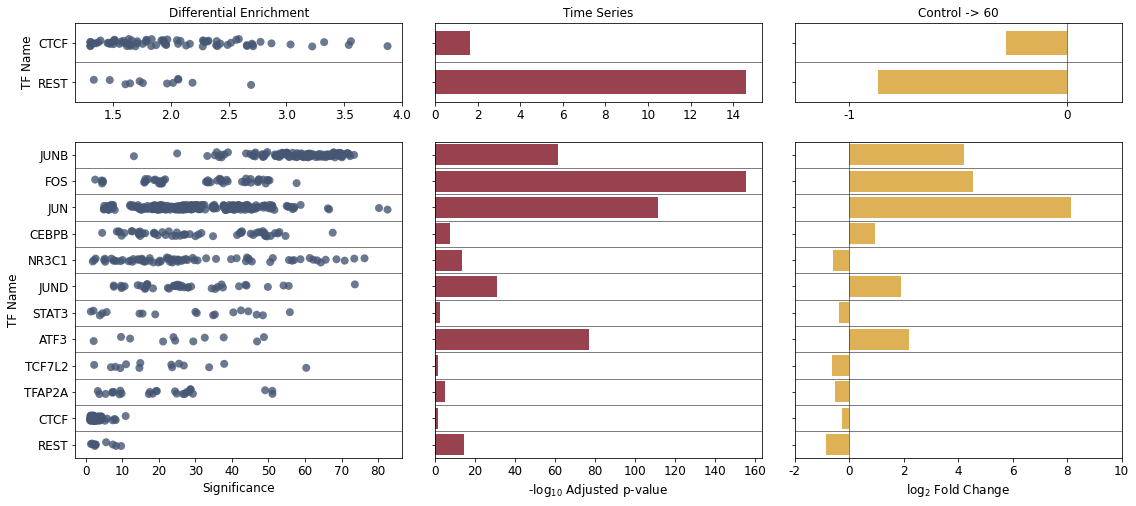

In [42]:
comp = "t0_t12"

topN = 10
min_exp = 10
# ratio between ax1 and ax2
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25/4*3, 8), gridspec_kw={"hspace": 0.2, "wspace": 0.1, 'height_ratios': [1, 4]}, sharey="row")

for i, vs_name in enumerate(["0_1_vs_1_0" , "1_0_vs_0_1"]):
    data = pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/unibind/gnn_res/gnn_{vs_name}/allEnrichments.tsv", sep="\t", header=0)
    data = prep_data(data, topN=topN, use_stat="mean", filter_count=min_exp, deseq_lrt=deseq_lrt, return_additional=["CTCF", "REST"], how="inner")

    s = sns.stripplot(
        x = "pValueLog", 
        y = "collection",
        data=data, 
        s=8, 
        ax = ax[i][0], 
        palette = ["#465774"],
        alpha=0.8)

    s.set_ylabel("TF Name", fontsize=2)

    # subscript 10
    ss_10 = "$_{10}$"
    s.set_xlabel(f"Significance", fontsize=12)
    s.set_ylabel("TF Name", fontsize=12)
    if i == 0:
        # remove x label
        s.set_xlabel("")

    # change font size of x and y ticks

    s.tick_params(axis='both', which='major', labelsize=12)
    s.tick_params(axis='both', which='minor', labelsize=12)
    s.set_title(f"Differential Enrichment", fontsize=12) if i == 0 else None

    # add vertical lines between each x label
    lineRange = data.collection.nunique() - 1
    for l in range(lineRange):
        s.axhline(l + 0.5, color='black', lw=0.5)

    # add log_ts_padj to the bottom right of each panel
    tfs_in = data.collection.unique()
    # for tf in tfs_in:
    #     x = .9 if i == 0 else -12
    #     s.text(x, np.where(tfs_in == tf)[0][0] + .30, f"{data.loc[data['collection'] == tf, 'log_ts_padj'].iloc[0]:.1f}", fontsize=10, color="#A63446")
    log_padjs = []
    for tf in tfs_in:
        log_padj = data.loc[data['collection'] == tf, 'log_ts_padj'].iloc[0]
        log_padjs.append(log_padj)
    b = sns.barplot(x=log_padjs, y=tfs_in, ax=ax[i][1], color="#A63446", width=0.6) if i == 0 else sns.barplot(x=log_padjs, y=tfs_in, ax=ax[i][1], color="#A63446")
    b.set_ylabel("")
    b.set_xlabel(f"-log$_{{10}}$ Adjusted p-value", fontsize=12) if i == 1 else b.set_xlabel("")

    for l in range(lineRange):
        b.axhline(l + 0.5, color='black', lw=0.5)
    b.tick_params(axis='both', which='major', labelsize=12)
    b.tick_params(axis='both', which='minor', labelsize=12)
    b.set_title(f"Time Series", fontsize=12) if i == 0 else None


    log2fc = []
    tfs_in_fc = []
    for tf in tfs_in:
        if len(degs.loc[degs['external_gene_name'] == tf]) != 0:
            log2fc.append(degs.loc[degs['external_gene_name'] == tf, 'log2FoldChange'].iloc[0])
        else:
            log2fc.append(0)   
        tfs_in_fc.append(tf)

    
    if len(log2fc) > 0:
        b2 = sns.barplot(x=log2fc, y=tfs_in_fc, ax=ax[i][2], color="#F5B841", width=0.6) if i == 0 else sns.barplot(x=log2fc, y=tfs_in, ax=ax[i][2], color="#F5B841")
        # set margins
        if i == 0:
            b2.set_xlim(-1.25, .25)
        elif i == 1:
            b2.set_xlim(-2, 10)
        if i == 0:
            b2.set_xticks([-1, 0])
            b2.set_xticklabels([-1, 0])
        elif i == 1:
            b2.set_xticks([-2, 0, 2, 4, 6, 8, 10])
            b2.set_xticklabels([-2, 0, 2, 4, 6, 8, 10])
            
        b2.set_ylabel("")
        b2.set_xlabel(f"log$_{{2}}$ Fold Change", fontsize=12) if i == 1 else b.set_xlabel("")

        b2.axvline(x=0, color='black', lw=0.5)
        b2.tick_params(axis='both', which='major', labelsize=12)
        b2.tick_params(axis='both', which='minor', labelsize=12)
        b2.set_title(f"Control -> 60", fontsize=12) if i == 0 else None

    for l in range(lineRange):
        b2.axhline(l + 0.5, color='black', lw=0.5)

fig.set_tight_layout(True)
fig.savefig(f"gnn_0_1vs1_0_inner_lrt_f_{time_comp}.svg", bbox_inches='tight')
fig.savefig(f"gnn_0_1vs1_0_inner_lrt_f_{time_comp}.png", dpi=600, bbox_inches='tight')

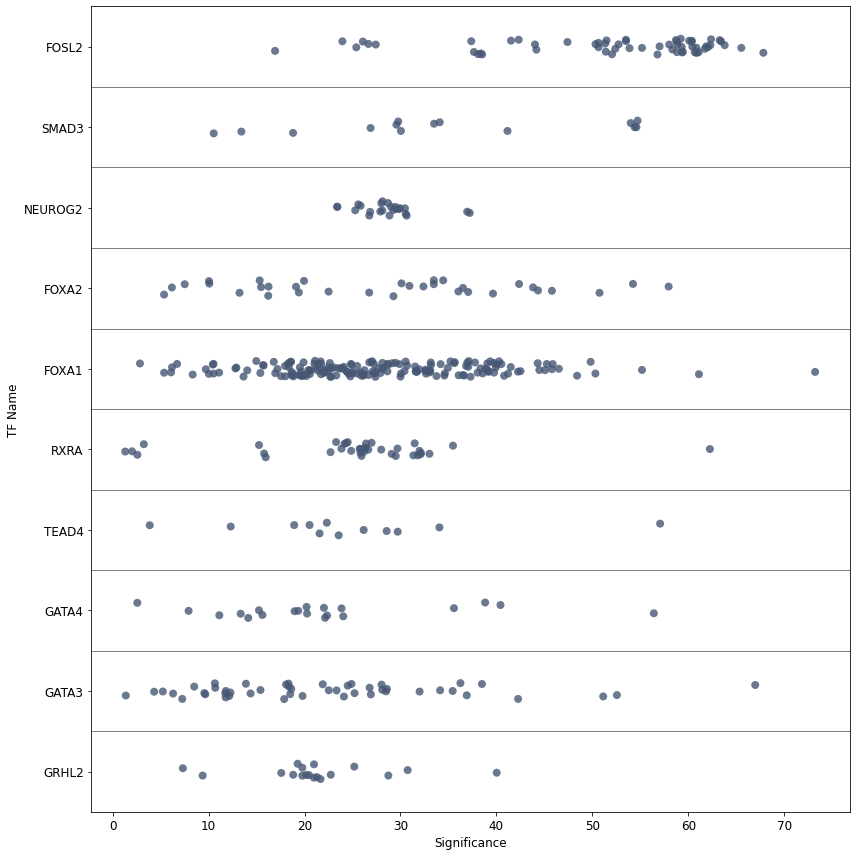

In [50]:
comp = "t0_t12"

topN = 10
min_exp = 10
# ratio between ax1 and ax2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))

for i, vs_name in enumerate(["1_0_vs_0_1"]): # only 1_0_vs_0_1 because it only has significant TFs
    data = pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/unibind/gnn_res/gnn_{vs_name}/allEnrichments.tsv", sep="\t", header=0)
    data = prep_data(data, topN=topN, use_stat="mean", filter_count=min_exp, deseq_lrt=deseq_lrt, return_additional=None, how="outer")

    s = sns.stripplot(
        x = "pValueLog", 
        y = "collection",
        data=data, 
        s=8, 
        ax = ax, 
        palette = ["#465774"],
        alpha=0.8)

    # subscript 10
    ss_10 = "$_{10}$"
    s.set_xlabel(f"Significance", fontsize=12)
    s.set_ylabel(f"TF Name", fontsize=12)

    
    # change font size of x and y ticks
    s.tick_params(labelsize=8)
    s.tick_params(axis='both', which='major', labelsize=12)
    s.tick_params(axis='both', which='minor', labelsize=12)
    # add vertical lines between each x label
    lineRange = data.collection.nunique() - 1
    for l in range(lineRange):
        s.axhline(l + 0.5, color='black', lw=0.5)

fig.set_tight_layout(True)
fig.savefig(f"gnn_0_1vs1_0_outer_lrt_f_{time_comp}.svg", bbox_inches='tight')
fig.savefig(f"gnn_0_1vs1_0_outer_lrt_f_{time_comp}.png", dpi=600, bbox_inches='tight')

## loop anchor res

In [12]:
data

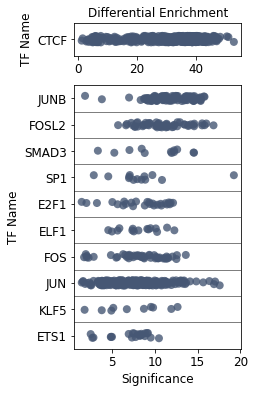

In [28]:
val = "pValue"
topN = 10
min_exp = 10
#fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.1, 'height_ratios': [1, 4]}, sharey="row")
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.1, 'height_ratios': [.5, 4]}, sharey="row")



comps = ["t0_t12_2_1", "t0_t12_1_2"]

for i, comp in enumerate(comps):
    data = pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/unibind/anchor_res/{comp}/allEnrichments.tsv", sep="\t", header=0)
    data = prep_data(data, topN=topN, use_stat="mean", filter_count=min_exp, deseq_lrt=deseq_lrt, return_additional=["CTCF"], how="inner", filter_cont=False)

    s = sns.stripplot(
        x = "pValueLog", 
        y = "collection",
        data=data, 
        s=8, 
        ax = ax[i],
        #ax = ax[i][0], 
         
        palette = ["#465774"],
        alpha=0.8)

    s.set_ylabel("TF Name", fontsize=2)

    # subscript 10
    ss_10 = "$_{10}$"
    s.set_xlabel(f"Significance", fontsize=12)
    s.set_ylabel("TF Name", fontsize=12)
    if i == 0:
        # remove x label
        s.set_xlabel("")

    # change font size of x and y ticks

    s.tick_params(axis='both', which='major', labelsize=12)
    s.tick_params(axis='both', which='minor', labelsize=12)
    s.set_title(f"Differential Enrichment", fontsize=12) if i == 0 else None

    # add vertical lines between each x label
    lineRange = data.collection.nunique() - 1
    for l in range(lineRange):
        s.axhline(l + 0.5, color='black', lw=0.5)

    # # add log_ts_padj to the bottom right of each panel
    # tfs_in = data.collection.unique()
    # # for tf in tfs_in:
    # #     x = .9 if i == 0 else -12
    # #     s.text(x, np.where(tfs_in == tf)[0][0] + .30, f"{data.loc[data['collection'] == tf, 'log_ts_padj'].iloc[0]:.1f}", fontsize=10, color="#A63446")
    # log_padjs = []
    # for tf in tfs_in:
    #     log_padj = data.loc[data['collection'] == tf, 'log_ts_padj'].iloc[0]
    #     log_padjs.append(log_padj)
    # b = sns.barplot(x=log_padjs, y=tfs_in, ax=ax[i][1], color="#A63446", width=0.6) if i == 0 else sns.barplot(x=log_padjs, y=tfs_in, ax=ax[i][1], color="#A63446")
    # b.set_ylabel("")
    # b.set_xlabel(f"-log$_{{10}}$ Adjusted p-value", fontsize=12) if i == 1 else b.set_xlabel("")

    # for l in range(lineRange):
    #     b.axhline(l + 0.5, color='black', lw=0.5)
    # b.tick_params(axis='both', which='major', labelsize=12)
    # b.tick_params(axis='both', which='minor', labelsize=12)
    # b.set_title(f"Time Series", fontsize=12) if i == 0 else None


    # log2fc = []
    # tfs_in_fc = []
    # for tf in tfs_in:
    #     if len(degs.loc[degs['external_gene_name'] == tf]) != 0:
    #         log2fc.append(degs.loc[degs['external_gene_name'] == tf, 'log2FoldChange'].iloc[0])
    #     else:
    #         log2fc.append(0)   
    #     tfs_in_fc.append(tf)

    
    # if len(log2fc) > 0:
    #     b2 = sns.barplot(x=log2fc, y=tfs_in_fc, ax=ax[i][2], color="#F5B841", width=0.6) if i == 0 else sns.barplot(x=log2fc, y=tfs_in, ax=ax[i][2], color="#F5B841")
    #     # set margins
    #     if i == 0:
    #         b2.set_xlim(-1.25, .25)
    #     elif i == 1:
    #         b2.set_xlim(-2, 10)
    #     if i == 0:
    #         b2.set_xticks([-1, 0])
    #         b2.set_xticklabels([-1, 0])
    #     elif i == 1:
    #         b2.set_xticks([-2, 0, 2, 4, 6, 8, 10])
    #         b2.set_xticklabels([-2, 0, 2, 4, 6, 8, 10])
            
    #     b2.set_ylabel("")
    #     b2.set_xlabel(f"log$_{{2}}$ Fold Change", fontsize=12) if i == 1 else b.set_xlabel("")

    #     b2.axvline(x=0, color='black', lw=0.5)
    #     b2.tick_params(axis='both', which='major', labelsize=12)
    #     b2.tick_params(axis='both', which='minor', labelsize=12)
    #     b2.set_title(f"Control -> 60", fontsize=12) if i == 0 else None

    # for l in range(lineRange):
    #     b2.axhline(l + 0.5, color='black', lw=0.5)

        
fig.set_tight_layout(True)

fig.savefig(f"anchors_{time_comp}.svg")
fig.savefig(f"anchors_{time_comp}.png", dpi=600)

In [21]:
# val = "pValue"
# topN = 10
# min_exp = 10
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))


# comps = ["t0_t12_2_1", "t0_t12_1_2"]

# for i, comp in enumerate(comps):
#     data = pd.read_csv(f"/home/carlos/Desktop/manuscripts/notebooks/unibind/anchor_res/{comp}/allEnrichments.tsv", sep="\t", header=0)
#     data = prep_data(data, topN=topN, use_stat="mean", filter_count=min_exp, deseq_lrt=deseq_lrt, return_additional=None, how="outer")

#     s = sns.stripplot(
#         x = "pValueLog", 
#         y = "collection",
#         data=data, 
#         s=8, 
#         ax = ax, 
#         palette = ["#465774"],
#         alpha=0.8)

#     # subscript 10
#     ss_10 = "$_{10}$"
#     s.set_xlabel(f"Significance", fontsize=12)
#     s.set_ylabel(f"TF Name", fontsize=12)

    
#     # change font size of x and y ticks
#     s.tick_params(labelsize=8)
#     s.tick_params(axis='both', which='major', labelsize=12)
#     s.tick_params(axis='both', which='minor', labelsize=12)
#     # add vertical lines between each x label
#     lineRange = data.collection.nunique() - 1
#     for l in range(lineRange):
#         s.axhline(l + 0.5, color='black', lw=0.5)

# fig.set_tight_layout(True)
# fig.savefig(f"anchors_0vs12_outer_lrt_f_{time_comp}.svg")
# fig.savefig(f"anchors_0vs12_outer_lrt_f_{time_comp}.png", dpi=600)